**IMPORTING THE LIBRARIES**

In [81]:
import pandas as pd                       # for data manipulation
import numpy as np                                 # for numerical computing
import matplotlib.pyplot as plt               # for visualization
import seaborn as sns                                       # for advanced visualization
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # for plotting of acf and pacf charts
from statsmodels.tsa.arima.model import ARIMA                   # for model
from sklearn.metrics import mean_absolute_error                                        # for evaluation
import plotly.express as px
import time



**FUNCTION FOR FILTERING THE DATA**

*TESTING FOR HUMIDITY ONLY*

*MADE A PIVOT TABLE OF THE COLUMNS NEEDED FOR THE PROJECT*

*CONVERTED THE TIMESTAMP TO DATETIME DATA TYPE BECAUSE IT CAMSE AS AN OBJECT*

*CONVERTED THE TIMESTAMP TO THE AFRICA/NAIROBI TIMEZONE NEEDED*

*CREATED OF RESAMPLE_RULE FOR THE DATA IN THIS CASE **1H** THAT CAN BE CHANGED IF NEEDED AND DID A FORWARD FILL TO FILL THE NULL VALUES CREATED BY THE RESAMPLE _RULE*


In [ ]:
   # function for filtering and resample rule adjustmentr incase the interval has to be increased
def wrangle(filepath, sep, resample_rule='1H'):
    df = pd.read_csv(filepath, sep=';')

    # filtering the data for the humidity reading
    df = df[df['value_type'] == 'humidity']


    # creating a dataframe of the values needed 
    df = df.pivot_table(index='timestamp', columns= 'value_type', values = 'value' )

   # reset index to convert the timestamp into a date time format
    df.reset_index(inplace=True)
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    
   # resetting timestamp as index to convert it to Africa/Nairobi timezone
    df.set_index('timestamp', inplace = True)
    df.index = df.index.tz_convert('Africa/Nairobi')

   # resampling the data to 1H interval
    df = df['humidity'].resample(resample_rule).mean().fillna(method='ffill')

    return df


In [ ]:
df = wrangle(r'C:\Users\USER\Desktop\PROJECTS\air- quality in nairobi.csv', sep=';')
df.shape


C:\Users\USER\AppData\Local\Temp\ipykernel_12004\767909456.py:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df['humidity'].resample(resample_rule).mean().fillna(method='ffill')
C:\Users\USER\AppData\Local\Temp\ipykernel_12004\767909456.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df['humidity'].resample(resample_rule).mean().fillna(method='ffill')


(720,)

In [ ]:
df.head()


timestamp
2018-04-01 03:00:00+03:00    69.342857
2018-04-01 04:00:00+03:00    68.126923
2018-04-01 05:00:00+03:00    70.653125
2018-04-01 06:00:00+03:00    71.518182
2018-04-01 07:00:00+03:00    73.140385
Freq: h, Name: humidity, dtype: float64

**STATISTICAL INFORMATION CF THE DATA**

In [ ]:
df.describe()


count    720.000000
mean      71.599341
std       10.757373
min       36.383333
25%       63.918182
50%       73.540716
75%       80.327536
max       92.733333
Name: humidity, dtype: float64

**HISTOGRAM PLOT OF THE DATA**

<Axes: >

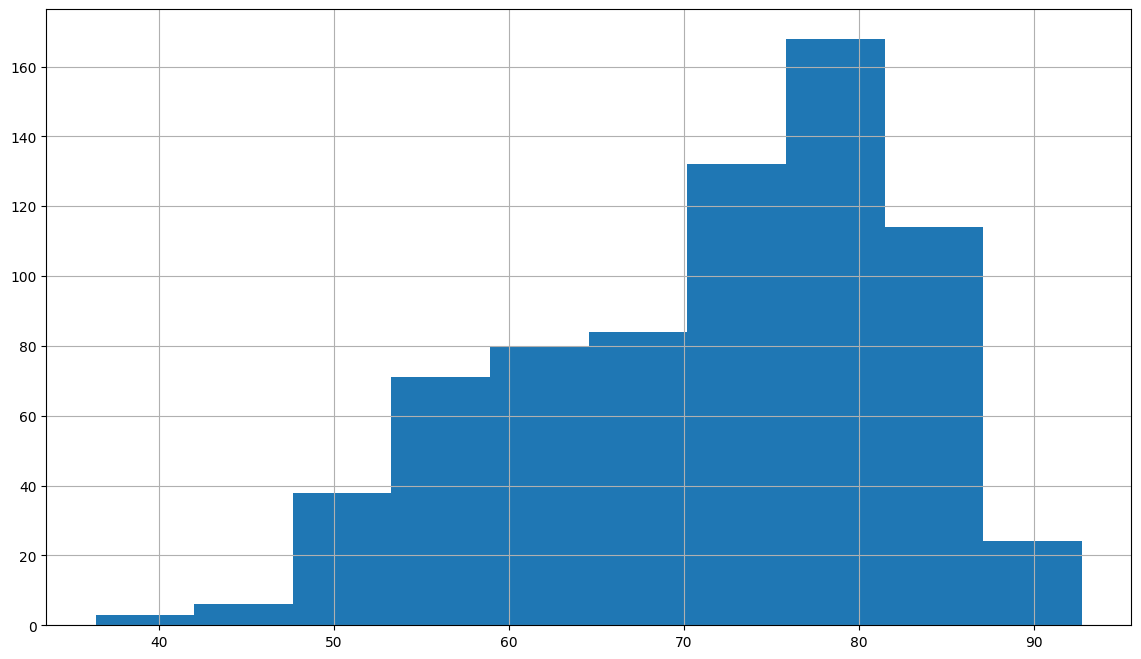

In [ ]:
df.hist(figsize=(14, 8))


**PLOTTING THE AUTOCORRELATION FUNCTION PLOT**



**we can see there are positive[0 - 5HOURS] and negative correlation[7 - 15HOURS] and then moved back to positive correlation from[20-27HOURS]*

Text(0, 0.5, 'Correlation Coefficients')

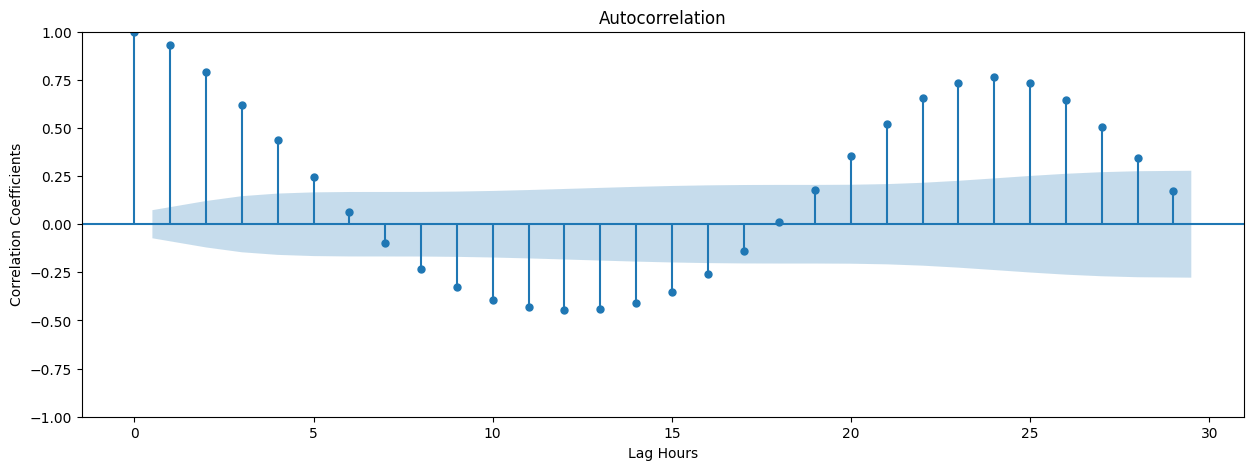

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
plot_acf(df, ax=ax)
plt.xlabel('Lag Hours')
plt.ylabel('Correlation Coefficients')


**PLOTTING THE PARTIAL CORRELATIO PLOT TO SHOW HOW FAR WE CAN GO BACK IN TIME TO SERVE AS OUR LAG TIME**

**we can see that from 1 - 2 hours theres been a change in correlation..though there a strong correlation but it changed from positive to negative between an hour mark*

*but we can now see we can't go beyond the hour mark of 26 for our time lag*

Text(0, 0.5, 'Correlation Coefficients')

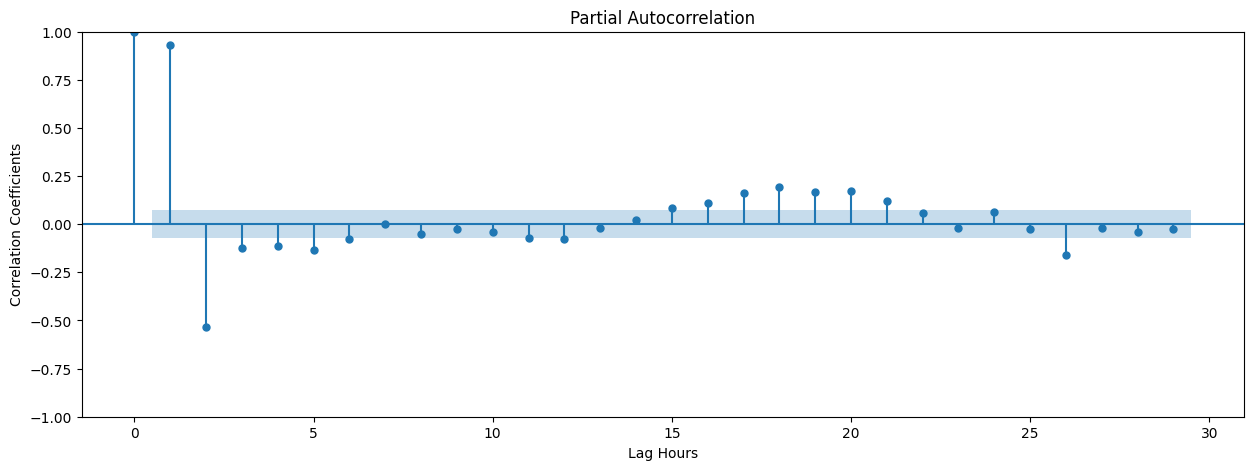

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
plot_pacf(df, ax=ax)
plt.xlabel('Lag Hours')
plt.ylabel('Correlation Coefficients')


**SPLITTING THE DATA INTO TRAINING AND TESTING SET**

*THE TRAINING DATA CONSIST OF DATA COLLECTED IN THE MONTH OF APRIL[04] WHILE THE TEST DATA CONSIST OF DATA COLLECTED IN THE MONTH OF MAY[05]*

In [ ]:
y_train = df['2018-04']
y_test = df['2018-05-01']
print(len(y_train))
print(len(y_test))


717
3


**CHECKING THE MEAN, Y_TRAIN BASELINE AND THE MEAN_ABSOLUTE_ERROR BASELINE**

In [ ]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print(f'the average of the training set : {y_train_mean}')
print(f'mean_absolute_error : {mae_baseline}')


the average of the training set : 71.58422376263381
mean_absolute_error : 8.989777365876131


**HYPER PARAMETERS OF THE MODEL (P_params stands for time lags, while Q_params stands for moving average**



In [ ]:
P_params = range(0, 26, 8)
Q_params = (0, 4, 1)
print(list(P_params))
print(list(Q_params))


[0, 8, 16, 24]
[0, 4, 1]


**MODEL BUILDING AND FITTING**

In [ ]:
mae_grid = dict()
# outer loop: iterate through the possible values of p
for p in P_params:
# create key value pair in dictionary    
    mae_grid[p] = list()
# inner loop: iterate through the possible values of q
    for q in Q_params:
# combination of hyper parameters for the model
      order = (p, 0, q)
# start time....
      start_time = time.time()
      model = ARIMA(y_train, order=(p, 0, q)).fit() # for each combination of the paremeters the ARIMA model fits the training data and calculates its mae
      elapsed_time = round(time.time() - start_time, 2) # time taken to fit each model
# calculate the sample predictions
      y_pred = model.predict()
#calculate mae
      mae = mean_absolute_error(y_train, y_pred)
# append mae to the dictionary
      mae_grid[p].append(mae)
      print(f'THE TRAINED ARIMA{order} in {elapsed_time} seconds')

  

THE TRAINED ARIMA(0, 0, 0) in 0.23 seconds


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


THE TRAINED ARIMA(0, 0, 4) in 0.48 seconds


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


THE TRAINED ARIMA(0, 0, 1) in 0.34 seconds
THE TRAINED ARIMA(8, 0, 0) in 0.5 seconds


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


THE TRAINED ARIMA(8, 0, 4) in 2.53 seconds
THE TRAINED ARIMA(8, 0, 1) in 2.18 seconds
THE TRAINED ARIMA(16, 0, 0) in 2.05 seconds


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


THE TRAINED ARIMA(16, 0, 4) in 10.38 seconds


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


THE TRAINED ARIMA(16, 0, 1) in 7.08 seconds
THE TRAINED ARIMA(24, 0, 0) in 14.78 seconds


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


THE TRAINED ARIMA(24, 0, 4) in 16.46 seconds
THE TRAINED ARIMA(24, 0, 1) in 14.71 seconds


**CONVERTING THE VALUES INTO A DATAFRAME**

*THIS IS OUR MEAN_ABSOLUTE ERRORS DERIVED FROM THE PARAMETERS*

*THE MEAN_ABSOLUTE ERROR IS THE PARAMETERS THAT ARE CLOSER TO ZERO*

In [ ]:
mae_grid =pd.DataFrame(mae_grid)
mae_grid


,0,8,16,24
0,8.989778,2.294003,2.255653,2.061301
1,2.803882,2.288418,2.195214,2.038296
2,5.210923,2.288461,2.126622,2.061114


*2.0 IS OUR MEAN_ABSOLUTE ERROR*

<Axes: >

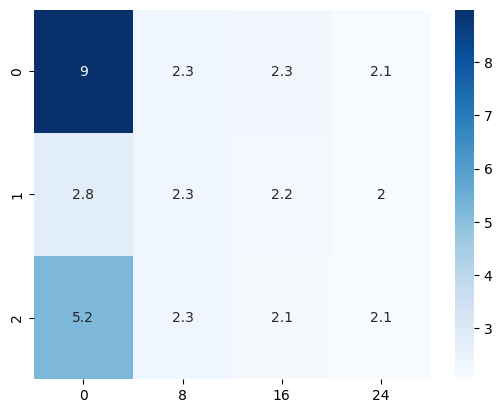

In [ ]:
sns.heatmap(mae_grid, cmap='Blues', annot=True)


**ARIMA PLOT DIAGNOSTICS**

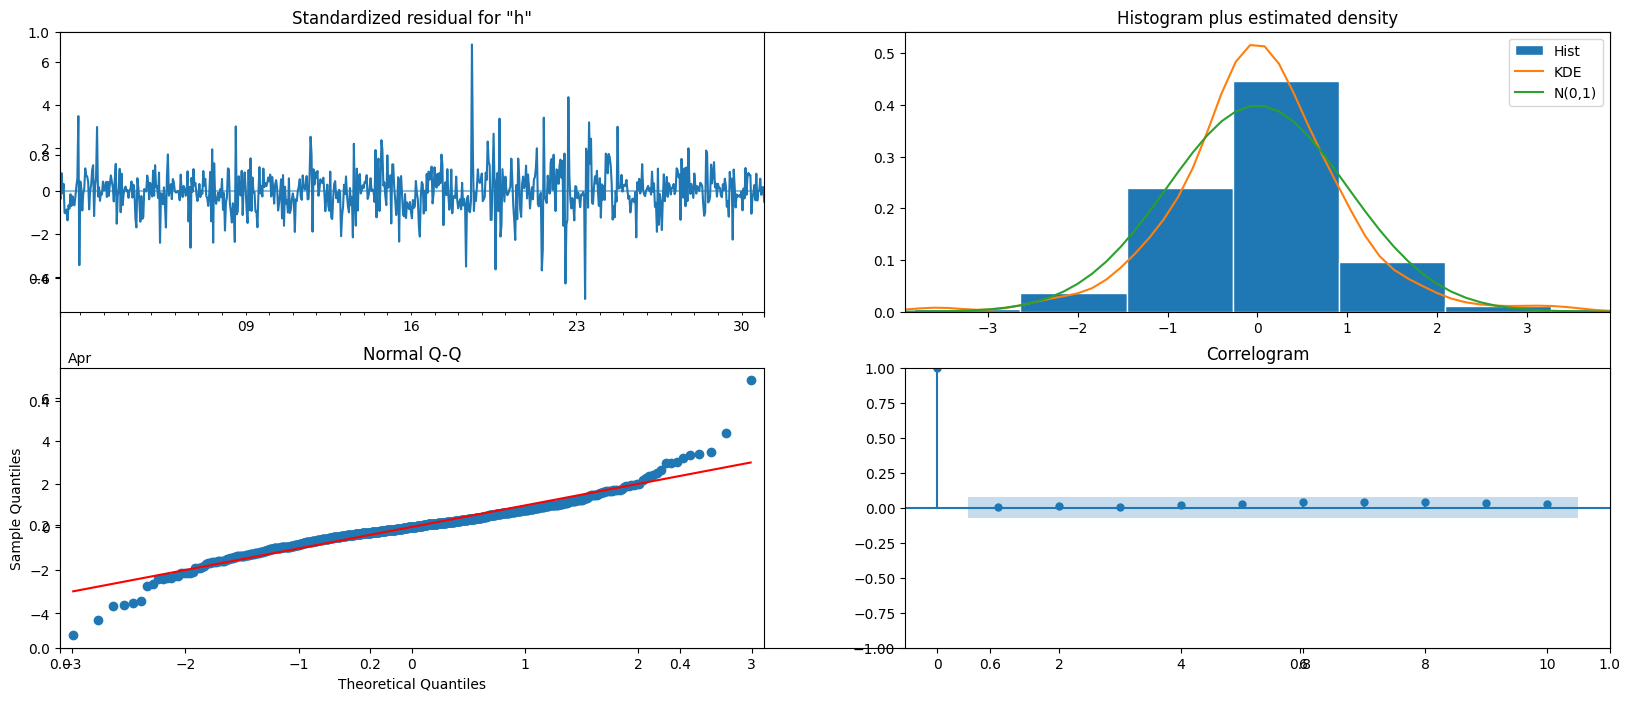

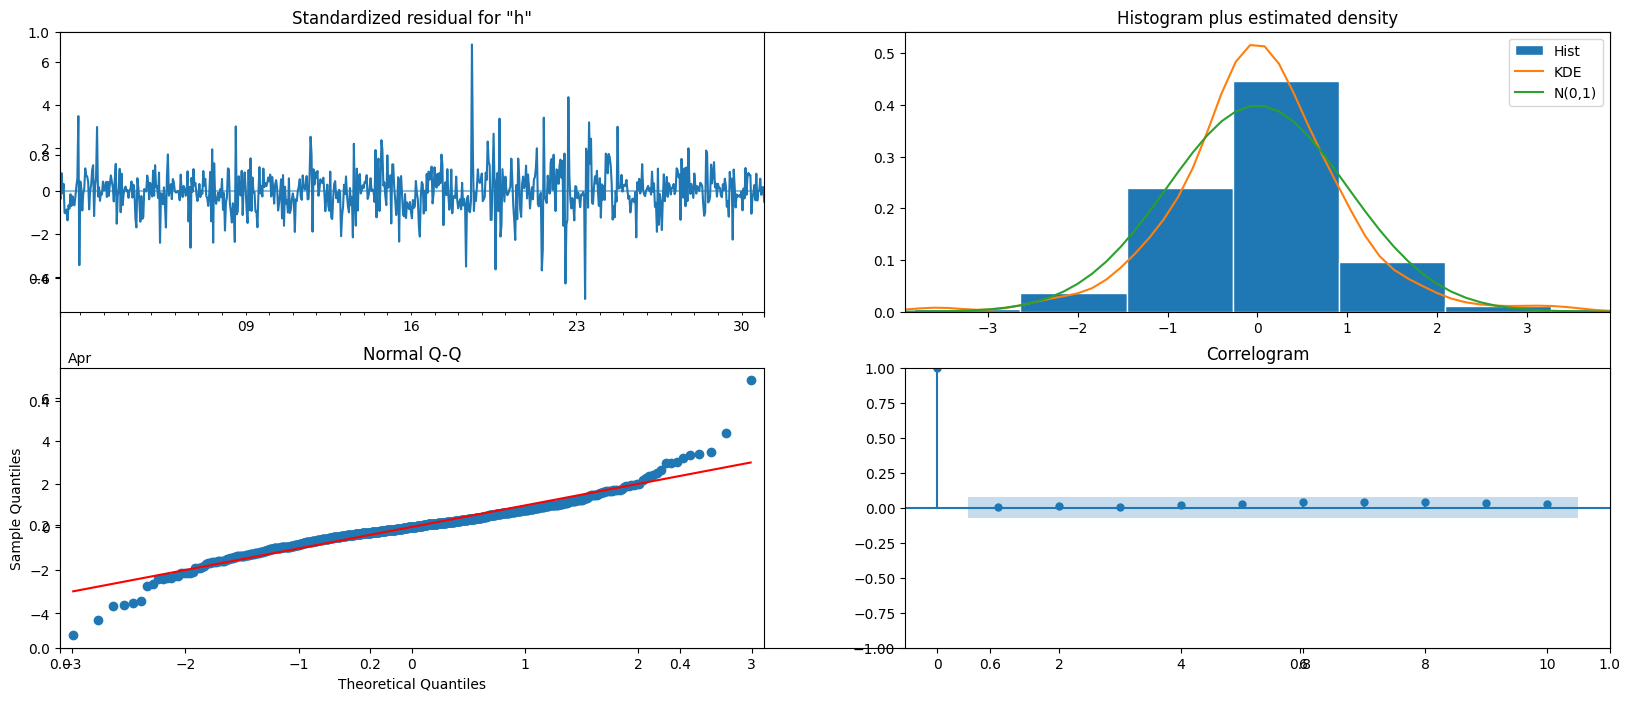

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))
model.plot_diagnostics(fig=fig)


*TRAINING DATA AND ITS PREDICTIONS*

In [ ]:
df_y_train = pd.DataFrame({
    'y_train':y_train,
    'y_pred': y_pred
})
df_y_train


,y_train,y_pred
timestamp,,
2018-04-01 03:00:00+03:00,69.342857,71.555941
2018-04-01 04:00:00+03:00,68.126923,69.500058
2018-04-01 05:00:00+03:00,70.653125,67.862170
2018-04-01 06:00:00+03:00,71.518182,71.823584
2018-04-01 07:00:00+03:00,73.140385,72.007070
...,...,...
2018-04-30 19:00:00+03:00,74.360345,72.642260
2018-04-30 20:00:00+03:00,76.724590,77.206296
2018-04-30 21:00:00+03:00,78.287037,77.788458


**EVALUATION PHASE**


*WALK FORWARD VALIDATION*

In [ ]:
y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
 model = ARIMA(history, order = (8, 0, 2)).fit()
 next_pred = model.forecast()
 y_pred_wfv = pd.concat([y_pred_wfv, next_pred])
 history = pd.concat([history, y_test[next_pred.index]])


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\USER\AppData\Local\Temp\ipykernel_12004\3929545553.py:6: FutureWarning:

The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



**OUR MEAN ABSOLUTE ERROR AFTER WALK FORWARD VALIDATION IS 1.5..**

*WHICH SHOWS OUR MODEL IMPROVED AFTER THE WALK FORWARD VALIDATION WAS DONE*

In [ ]:
test_mae = mean_absolute_error(y_test, y_pred_wfv)
test_mae.round(2)


1.55

*MY PREDICTIONS AFTER WALK FORWARD VALIDATIONS*

In [ ]:
test_mae_df = pd.DataFrame(
    {
    'y_test': y_test,
    'y_pred' : y_pred_wfv
})
test_mae_df


,y_test,y_pred
2018-05-01 00:00:00+03:00,75.217143,77.739473
2018-05-01 01:00:00+03:00,75.302941,73.456901
2018-05-01 02:00:00+03:00,75.117241,74.847134


*THE TESTING SET PREDICTIONS*

In [ ]:
fig = px.line(test_mae_df)

fig.show()
